In [1]:
import os
import numpy as np
import pandas as pd

import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

### データ読込

In [2]:
in_dir = '../data/two_years_each/train_val_skip'

df_train_X = pd.read_excel(os.path.join(in_dir, 'train_X.xlsx'), header=0, index_col=0)
df_train_Y = pd.read_excel(os.path.join(in_dir, 'train_Y.xlsx'), header=0, index_col=0)

df_val_X = pd.read_excel(os.path.join(in_dir, 'val_X.xlsx'), header=0, index_col=0)
df_val_Y = pd.read_excel(os.path.join(in_dir, 'val_Y.xlsx'), header=0, index_col=0)

### 目的変数の分布

C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[]

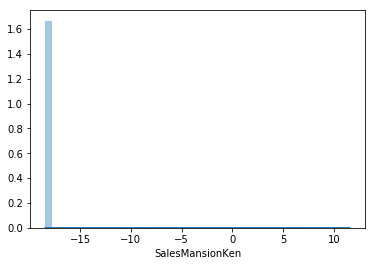

In [3]:
sns.distplot(np.log(df_train_Y['SalesMansionKen'] + 0.00000001))
plt.plot()

C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[]

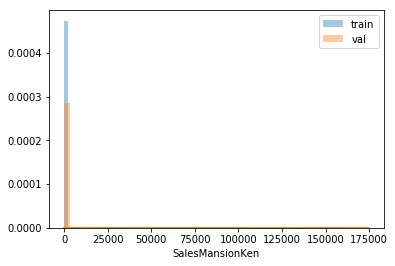

In [4]:
sns.distplot(df_train_Y['SalesMansionKen'], label='train')
sns.distplot(df_val_Y['SalesMansionKen'], label='val')
plt.legend()
plt.plot()

In [5]:
def log(x):
    return np.log(x + 0.00000001)

#for c in ['Sales', 'Impressions', 'Clicks', 'Cost']:
for c in ['SalesMansionKen']:
    df_train_Y['SalesMansionKen_log'] = df_train_Y['SalesMansionKen'].apply(log)
    df_val_Y['SalesMansionKen_log'] = df_val_Y['SalesMansionKen'].apply(log)

### データ構造転換

In [6]:
d_train_sales = xgb.DMatrix(df_train_X, label=df_train_Y['SalesMansionKen_log'])
d_val_sales = xgb.DMatrix(df_val_X, label=df_val_Y['SalesMansionKen_log'])

d_val = xgb.DMatrix(df_val_X)

C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


### xgboost モデルの作成

In [7]:
params = {
    'max_depth': 10,
    'learning_rate': 0.1,
    'n_estimators': 1500,
    'objective': 'reg:squarederror',
    'n_jobs': -1,
    'reg_alpha': 10,
    'reg_lambda':10,
}

evals = [(d_train_sales, 'train'), (d_val_sales, 'eval')]
evals_result = {}

model = xgb.train(params, 
          d_train_sales, 
          num_boost_round=100, 
          evals=evals,
          evals_result=evals_result)

[0]	train-rmse:17.0272	eval-rmse:16.9958
[1]	train-rmse:15.3279	eval-rmse:15.3126
[2]	train-rmse:13.7968	eval-rmse:13.8037
[3]	train-rmse:12.4201	eval-rmse:12.4473
[4]	train-rmse:11.1814	eval-rmse:11.234
[5]	train-rmse:10.0662	eval-rmse:10.1462
[6]	train-rmse:9.06186	eval-rmse:9.17154
[7]	train-rmse:8.15937	eval-rmse:8.30083
[8]	train-rmse:7.34756	eval-rmse:7.52363
[9]	train-rmse:6.61758	eval-rmse:6.831
[10]	train-rmse:5.96037	eval-rmse:6.21474
[11]	train-rmse:5.37021	eval-rmse:5.66723
[12]	train-rmse:4.83863	eval-rmse:5.18169
[13]	train-rmse:4.36141	eval-rmse:4.75485
[14]	train-rmse:3.93261	eval-rmse:4.37995
[15]	train-rmse:3.54681	eval-rmse:4.05239
[16]	train-rmse:3.20036	eval-rmse:3.76653
[17]	train-rmse:2.89004	eval-rmse:3.51913
[18]	train-rmse:2.6112	eval-rmse:3.30544
[19]	train-rmse:2.36118	eval-rmse:3.12254
[20]	train-rmse:2.13729	eval-rmse:2.96728
[21]	train-rmse:1.93661	eval-rmse:2.83632
[22]	train-rmse:1.75684	eval-rmse:2.72665
[23]	train-rmse:1.59648	eval-rmse:2.6352
[24]	tr

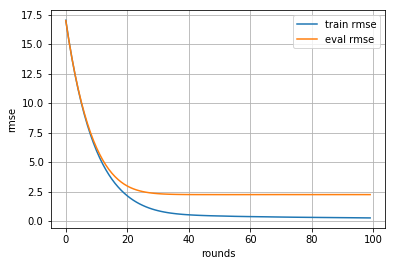

In [8]:
train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')
eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.show()

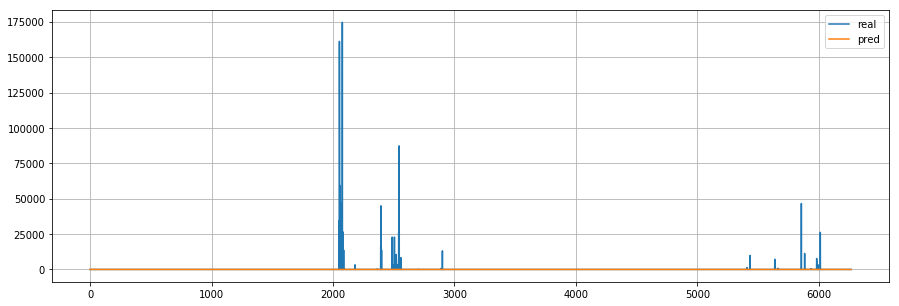

In [9]:
d_pred_log = model.predict(d_val)
d_pred = np.exp(d_pred_log)

#plt.plot(d_pred)
plt.figure(figsize=(15,5))
plt.plot(df_val_Y['SalesMansionKen'].values, label='real')
plt.plot(d_pred, label='pred')
plt.legend()
plt.grid()
plt.show()

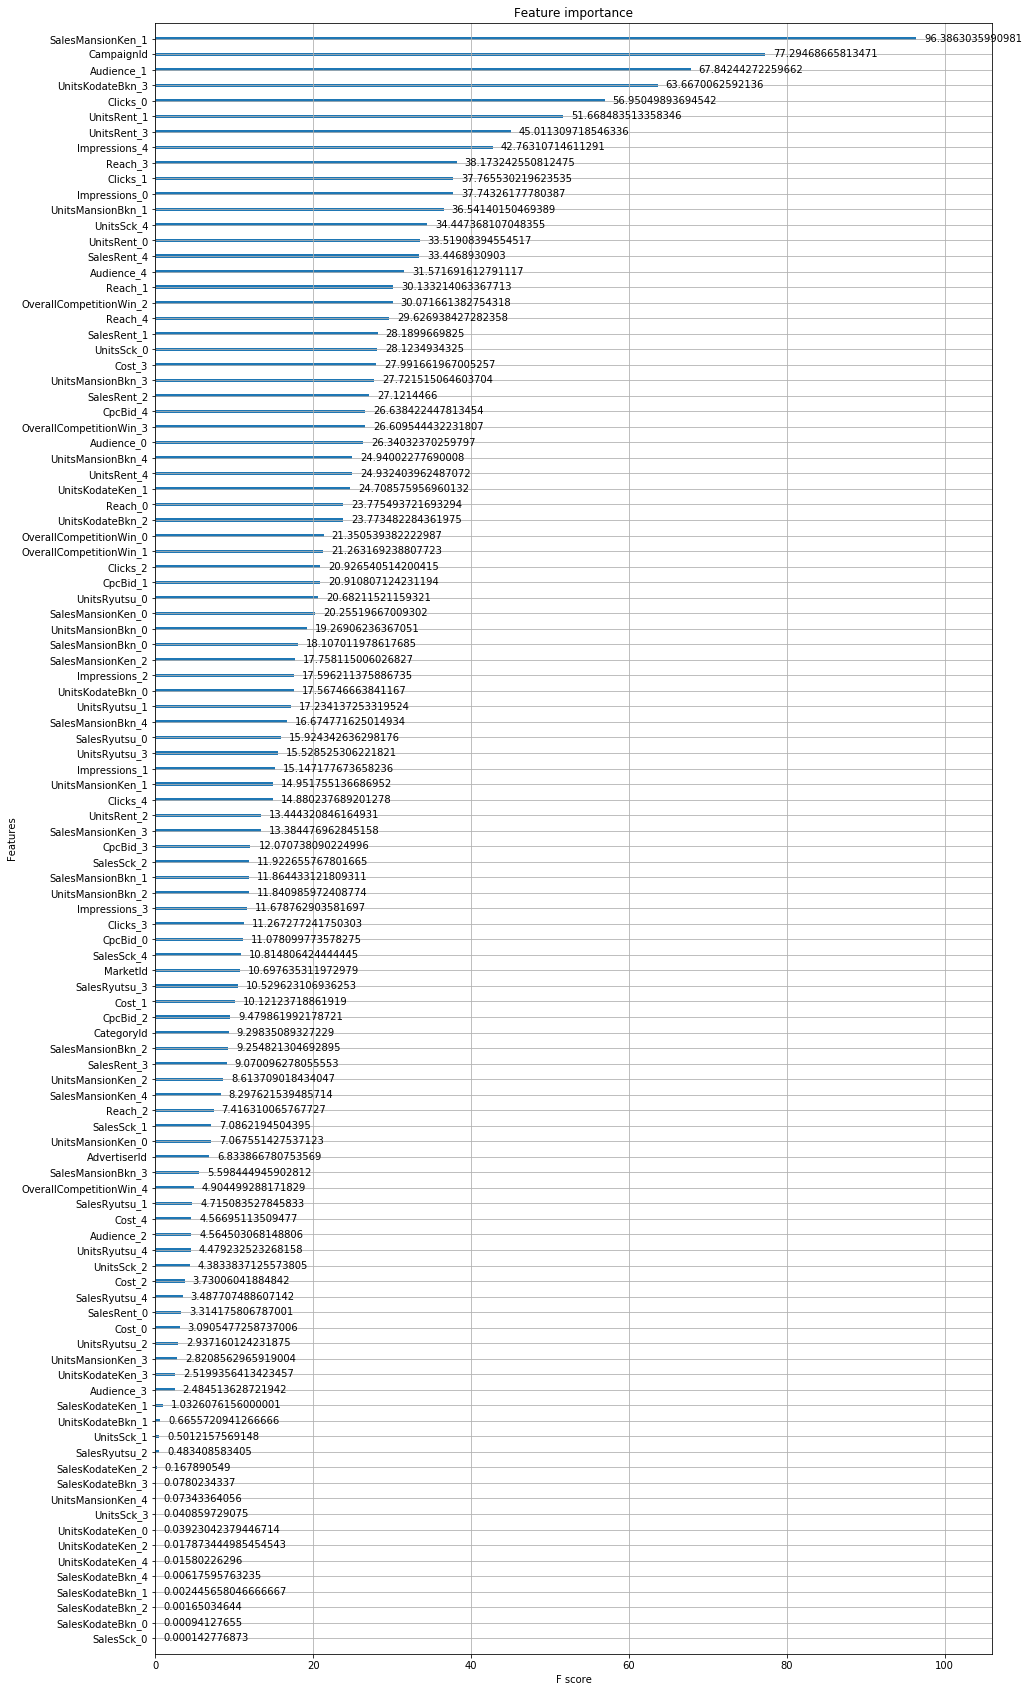

In [10]:
_, ax = plt.subplots(figsize=(15,30))
xgb.plot_importance(model, ax=ax, importance_type='gain')
plt.show()

In [11]:
m = model.get_score(importance_type='gain')
sorted(m, key=lambda x: m[x], reverse=True)

['SalesMansionKen_1',
 'CampaignId',
 'Audience_1',
 'UnitsKodateBkn_3',
 'Clicks_0',
 'UnitsRent_1',
 'UnitsRent_3',
 'Impressions_4',
 'Reach_3',
 'Clicks_1',
 'Impressions_0',
 'UnitsMansionBkn_1',
 'UnitsSck_4',
 'UnitsRent_0',
 'SalesRent_4',
 'Audience_4',
 'Reach_1',
 'OverallCompetitionWin_2',
 'Reach_4',
 'SalesRent_1',
 'UnitsSck_0',
 'Cost_3',
 'UnitsMansionBkn_3',
 'SalesRent_2',
 'CpcBid_4',
 'OverallCompetitionWin_3',
 'Audience_0',
 'UnitsMansionBkn_4',
 'UnitsRent_4',
 'UnitsKodateKen_1',
 'Reach_0',
 'UnitsKodateBkn_2',
 'OverallCompetitionWin_0',
 'OverallCompetitionWin_1',
 'Clicks_2',
 'CpcBid_1',
 'UnitsRyutsu_0',
 'SalesMansionKen_0',
 'UnitsMansionBkn_0',
 'SalesMansionBkn_0',
 'SalesMansionKen_2',
 'Impressions_2',
 'UnitsKodateBkn_0',
 'UnitsRyutsu_1',
 'SalesMansionBkn_4',
 'SalesRyutsu_0',
 'UnitsRyutsu_3',
 'Impressions_1',
 'UnitsMansionKen_1',
 'Clicks_4',
 'UnitsRent_2',
 'SalesMansionKen_3',
 'CpcBid_3',
 'SalesSck_2',
 'SalesMansionBkn_1',
 'UnitsMansio